# Data Preporation

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

### Define classes and structure

In [2]:
data_dir = 'data/train'
classes = os.listdir(data_dir)
num_classes = len(classes)
print(f'Classes: {classes}')
print(f'Number of classes: {num_classes}')

Classes: ['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']
Number of classes: 5


### Define transformations

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

### Load dataset

In [4]:
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

### Split dataset

In [5]:
train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

### Create data loaders

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

print(f'Training set size: {train_size}')
print(f'Validation set size: {val_size}')

Training set size: 4807
Validation set size: 849


### Visualize class distribution

In [7]:
class_counts = Counter()
for cls in classes:
    class_counts[cls] = len(os.listdir(os.path.join(data_dir, cls)))

### Visualization

C:\Users\shaik\AppData\Local\Temp\ipykernel_16284\3811603362.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='viridis')


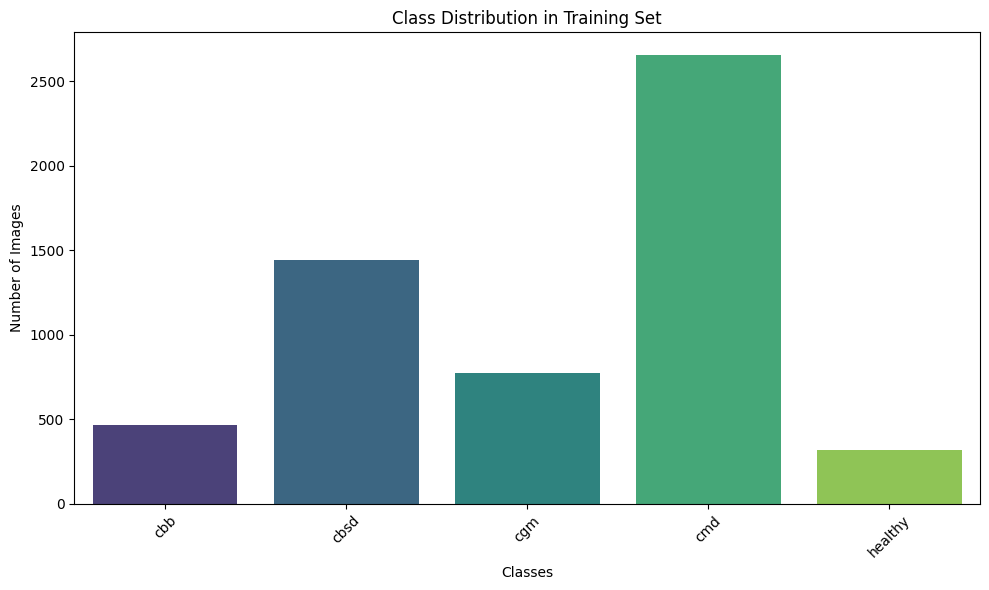

In [8]:
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='viridis')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Set')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Baseline Model

In [9]:
import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim

Checking cuda

In [10]:
torch.cuda.is_available()

True

### Define device

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


### Load and modify the model

In [12]:
num_classes = len(classes)
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

model = model.to(device)
print(model)

d:\Study\AML\cassava-disease-detection\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Study\AML\cassava-disease-detection\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Define loss function and optimizer

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

### Train the model

In [14]:
num_epochs = 10
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch [1/10], Loss: 0.9906
Validation Loss: 0.7900, Validation Accuracy: 0.7267
Epoch [2/10], Loss: 0.8166
Validation Loss: 0.8184, Validation Accuracy: 0.6914
Epoch [3/10], Loss: 0.7577
Validation Loss: 0.8485, Validation Accuracy: 0.6631
Epoch [4/10], Loss: 0.7191
Validation Loss: 0.6935, Validation Accuracy: 0.7527
Epoch [5/10], Loss: 0.7101
Validation Loss: 0.7426, Validation Accuracy: 0.7279
Epoch [6/10], Loss: 0.7236
Validation Loss: 0.7234, Validation Accuracy: 0.7314
Epoch [7/10], Loss: 0.7020
Validation Loss: 0.6564, Validation Accuracy: 0.7727
Epoch [8/10], Loss: 0.6894
Validation Loss: 0.6847, Validation Accuracy: 0.7550
Epoch [9/10], Loss: 0.6922
Validation Loss: 0.7006, Validation Accuracy: 0.7503
Epoch [10/10], Loss: 0.6933
Validation Loss: 0.7007, Validation Accuracy: 0.7527


In [15]:
torch.save(model.state_dict(), "models/resnet50_cassava.pth")
print("Baseline model saved successfully.")

Baseline model saved successfully.


In [16]:
train_losses_baseline = train_losses.copy()
val_losses_baseline = val_losses.copy()
val_accuracies_baseline = val_accuracies.copy()

train_losses = []
val_losses = []
val_accuracies = []

### Calculate evaluation metrics

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Precision: {precision:.4f}')
print(f'Validation Recall: {recall:.4f}')
print(f'Validation F1 Score: {f1:.4f}')

Validation Accuracy: 0.7644
Validation Precision: 0.7538
Validation Recall: 0.7644
Validation F1 Score: 0.7500


### Visualize losses and accuracy

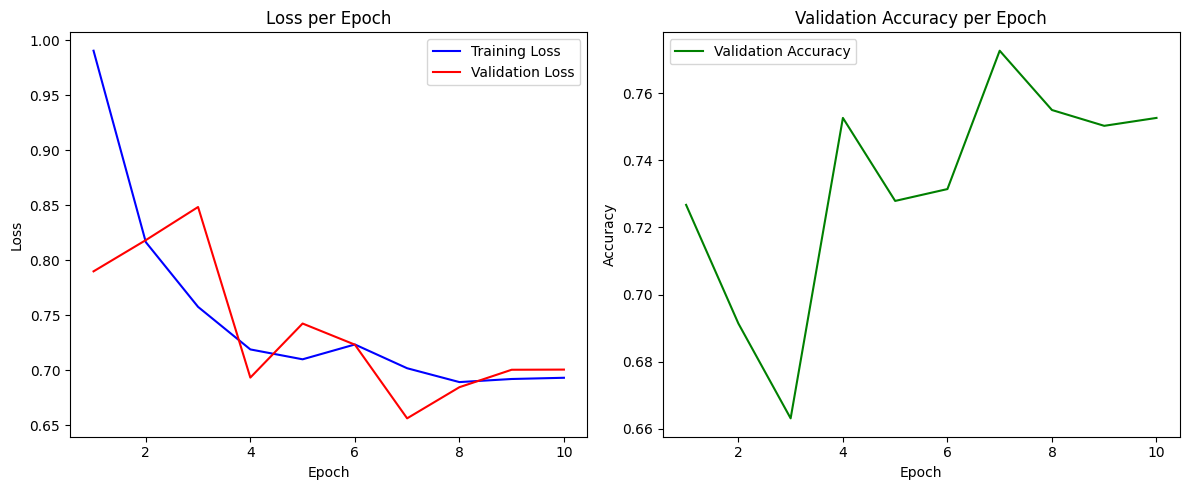

In [18]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_baseline, 'b-', label='Training Loss')
plt.plot(epochs, val_losses_baseline, 'r-', label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies_baseline, 'g-', label='Validation Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Enhanced Model

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

### Load and modify the model

In [20]:
num_classes = len(classes)
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = True

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)

model = model.to(device)
print(model)

d:\Study\AML\cassava-disease-detection\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Study\AML\cassava-disease-detection\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Define loss function and optimizer

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

### Train the enhanced model

In [22]:
num_epochs = 10
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    
    scheduler.step()

Epoch [1/10], Loss: 0.7648
Validation Loss: 0.5195, Validation Accuracy: 0.8245
Epoch [2/10], Loss: 0.4834
Validation Loss: 0.4455, Validation Accuracy: 0.8481
Epoch [3/10], Loss: 0.3555
Validation Loss: 0.5160, Validation Accuracy: 0.8316
Epoch [4/10], Loss: 0.2828
Validation Loss: 0.4346, Validation Accuracy: 0.8622
Epoch [5/10], Loss: 0.2350
Validation Loss: 0.4655, Validation Accuracy: 0.8504
Epoch [6/10], Loss: 0.1341
Validation Loss: 0.4137, Validation Accuracy: 0.8645
Epoch [7/10], Loss: 0.1038
Validation Loss: 0.4173, Validation Accuracy: 0.8563
Epoch [8/10], Loss: 0.0910
Validation Loss: 0.3951, Validation Accuracy: 0.8775
Epoch [9/10], Loss: 0.0748
Validation Loss: 0.4082, Validation Accuracy: 0.8728
Epoch [10/10], Loss: 0.0770
Validation Loss: 0.4183, Validation Accuracy: 0.8693


In [23]:
torch.save(model.state_dict(), "models/enhanced_resnet50_cassava.pth")
print("Enhanced model saved successfully.")

Enhanced model saved successfully.


In [24]:
train_losses_enhanced = train_losses.copy()
val_losses_enhanced = val_losses.copy()
val_accuracies_enhanced = val_accuracies.copy()

In [25]:
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        _, preds = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Enhanced Model Validation Accuracy: {accuracy:.4f}')
print(f'Enhanced Model Validation Precision: {precision:.4f}')
print(f'Enhanced Model Validation Recall: {recall:.4f}')
print(f'Enhanced Model Validation F1 Score: {f1:.4f}')

Enhanced Model Validation Accuracy: 0.8763
Enhanced Model Validation Precision: 0.8743
Enhanced Model Validation Recall: 0.8763
Enhanced Model Validation F1 Score: 0.8747


### Compare baseline and enhanced models

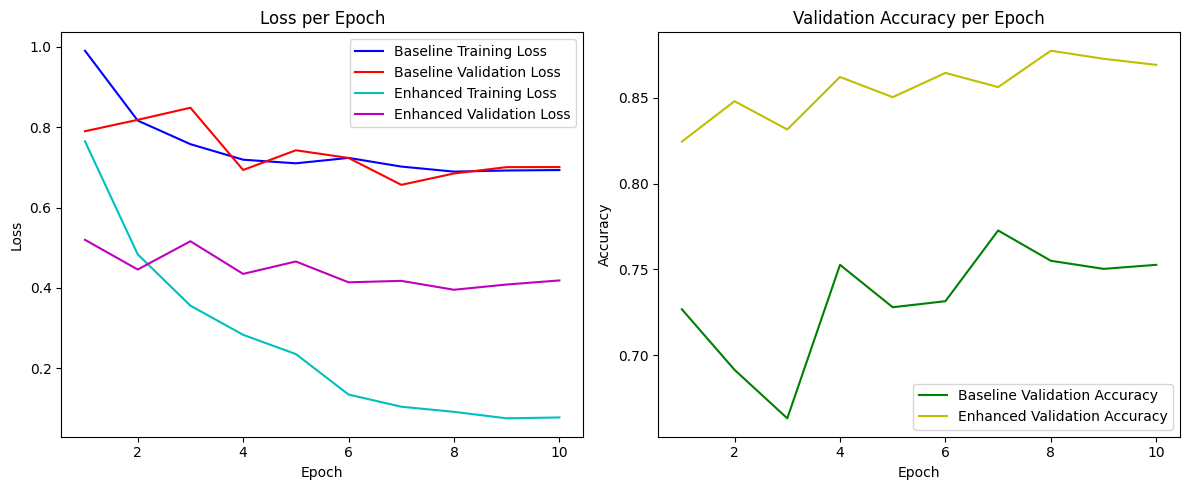

In [26]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_baseline, 'b-', label='Baseline Training Loss')
plt.plot(epochs, val_losses_baseline, 'r-', label='Baseline Validation Loss')
plt.plot(epochs, train_losses_enhanced, 'c-', label='Enhanced Training Loss')
plt.plot(epochs, val_losses_enhanced, 'm-', label='Enhanced Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies_baseline, 'g-', label='Baseline Validation Accuracy')
plt.plot(epochs, val_accuracies_enhanced, 'y-', label='Enhanced Validation Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()